# Plotting results of predictions




In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import odc.geo
import numpy as np
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject

import sys
sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools')
from dea_tools.temporal import allNaN_arg

## Analysis Parameters

In [2]:
var = 'NEE'
results_name = 'NEE_modelled_2003_2021.nc'

### Open datasets

In [3]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name)
ds.attrs['nodata'] = np.nan

var_fc = 'nee'
ds_fc = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/FLUXCOM/'+var_fc+'_rs_meteo_era5.nc').sel(time=slice('2003','2018')), crs='epsg:4326')
ds_fc = ds_fc.rename({'lat':'latitude', 'lon':'longitude'})
ds_fc.attrs['nodata'] = np.nan
ds_fc['latitude'] = ds_fc.latitude.astype('float32')
ds_fc['longitude'] = ds_fc.longitude.astype('float32')

Reproject predictions and fluxcom to match EPSG:3577 50km grid

In [4]:
grid = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/epsg3577_50km_grid.nc')

In [5]:
ds = xr_reproject(ds, geobox=grid.geobox, resampling='average')

mask = np.isnan(ds.isel(time=1))

/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [6]:
ds_fc = xr_reproject(ds_fc, geobox=grid.geobox, resampling='bilinear')
ds_fc = ds_fc.NEE.where(~mask.astype(bool))
ds_fc = ds_fc*30 #/day to /month

## Find area of pixels

In [7]:
area_per_pixel = ds.geobox.resolution[1] **2

Convert to total C in (petagrams) rather than gC/m2

In [8]:
ds = ds * area_per_pixel * 1e-15
ds_fc = ds_fc * area_per_pixel * 1e-15

## Zonal summaries

In [9]:
ds_1D = ds.sum(['x','y'])
ds_fc_1D = ds_fc.sum(['x','y'])

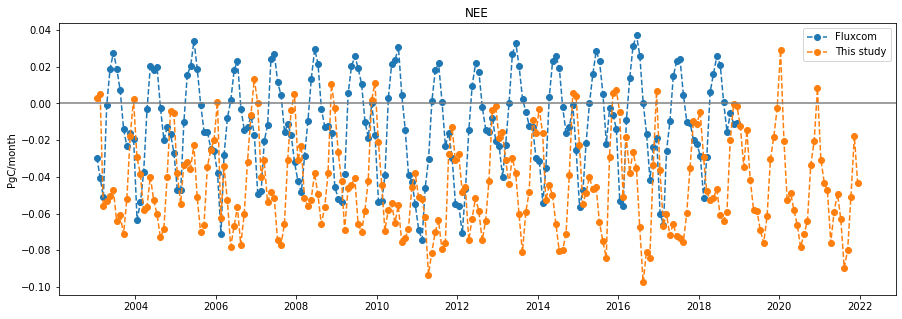

In [10]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(ds_fc_1D.time.values, ds_fc_1D, marker='o', linestyle='--', label='Fluxcom')
ax.plot(ds_1D.time.values, ds_1D, marker='o', linestyle='--', label='This study')
ax.legend(loc='upper right')
plt.axhline(0, c='grey')
plt.title(var)
plt.ylabel('PgC/month');


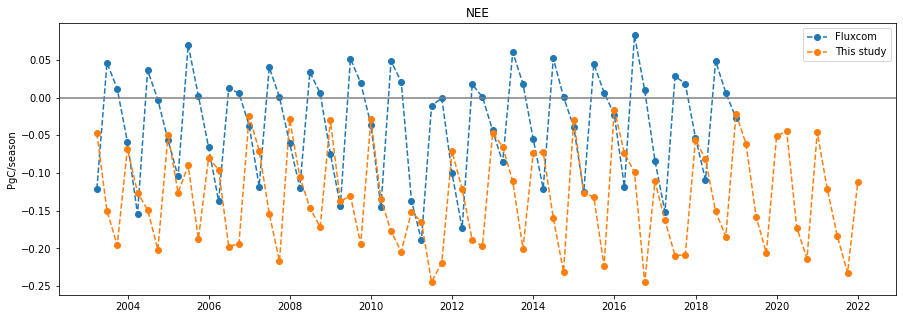

In [11]:
ds_1D_seasonal = ds.resample(time='Q-DEC').sum().sum(['x','y'])
ds_fc_1D_seasonal = ds_fc.resample(time='Q-DEC').sum().sum(['x','y'])
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(ds_fc_1D_seasonal.time.values, ds_fc_1D_seasonal, marker='o', linestyle='--', label='Fluxcom')
ax.plot(ds_1D_seasonal.time.values, ds_1D_seasonal, marker='o', linestyle='--', label='This study')
plt.axhline(0, c='grey')
plt.title(var)
ax.legend(loc='upper right')
plt.ylabel('PgC/season');

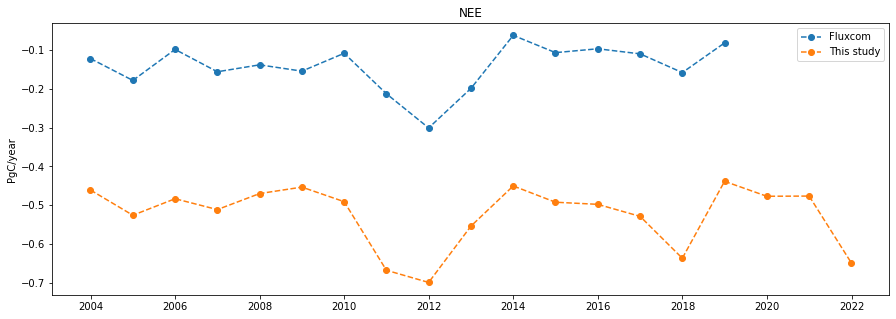

In [13]:
ds_1D_annual = ds.resample(time='1Y').sum().sum(['x','y'])
ds_fc_1D_annual = ds_fc.resample(time='1Y').sum().sum(['x','y'])
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(ds_fc_1D_annual.time.values, ds_fc_1D_annual, marker='o', linestyle='--', label='Fluxcom')
ax.plot(ds_1D_annual.time.values, ds_1D_annual, marker='o', linestyle='--', label='This study')
# plt.axhline(0, c='grey')
plt.title(var)
ax.legend(loc='upper right')
plt.ylabel('PgC/year');

## Climatology

In [14]:
import warnings
warnings.filterwarnings("ignore")

monthly_mean = ds.groupby('time.month').mean()
monthly_std = ds.groupby('time.month').std()
cv_monthly = monthly_std / monthly_mean

monthly_mean_fc = ds_fc.groupby('time.month').mean()
monthly_std_fc = ds_fc.groupby('time.month').std()
cv_monthly_fc = monthly_std_fc / monthly_mean_fc

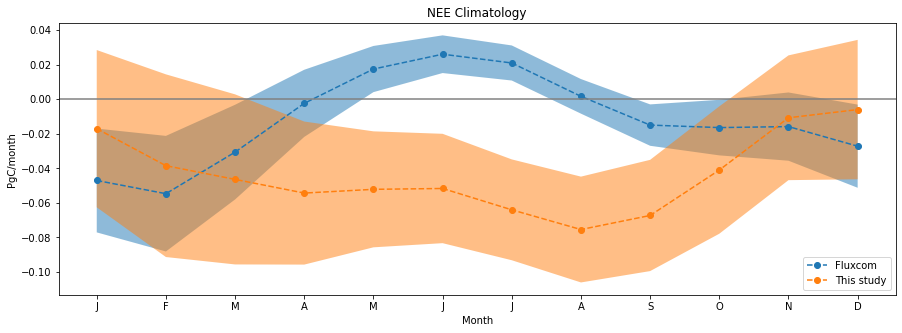

In [15]:
y = monthly_mean.where(~mask).sum(['x','y']).values
x = monthly_mean.month.values
std = monthly_std.where(~mask).sum(['x','y']).values

y_fc = monthly_mean_fc.where(~mask).sum(['x','y']).values
x_fc = monthly_mean_fc.month.values
std_fc = monthly_std_fc.where(~mask).sum(['x','y']).values

fig,ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(x_fc, y_fc, marker='o', linestyle='--', label='Fluxcom')
ax.plot(x, y, marker='o', linestyle='--', label='This study')
ax.axhline(0, c='grey')
ax.fill_between(x_fc, y_fc-std_fc, y_fc+std_fc, alpha=0.5)
ax.fill_between(x, y-std, y+std, alpha=0.5)
ax.legend(loc='lower right')
ax.set_title('NEE Climatology')
ax.set_xlabel('Month')
ax.set_xticks(range(1,13))
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"])             
ax.set_ylabel('PgC/month');


In [16]:
if var == 'NEE':
    max_mean_month = allNaN_arg(monthly_mean, 'month', 'min')
    max_mean_month_fc = allNaN_arg(monthly_mean_fc, 'month', 'min')
    #max_mean_season = allNaN_arg(monthly_season, 'season', 'min')
else:
    max_mean_month = allNaN_arg(monthly_mean, 'month', 'max')
    max_mean_month_fc = allNaN_arg(monthly_mean_fc, 'month', 'max')
    #max_mean_season = allNaN_arg(monthly_season, 'season', 'max')

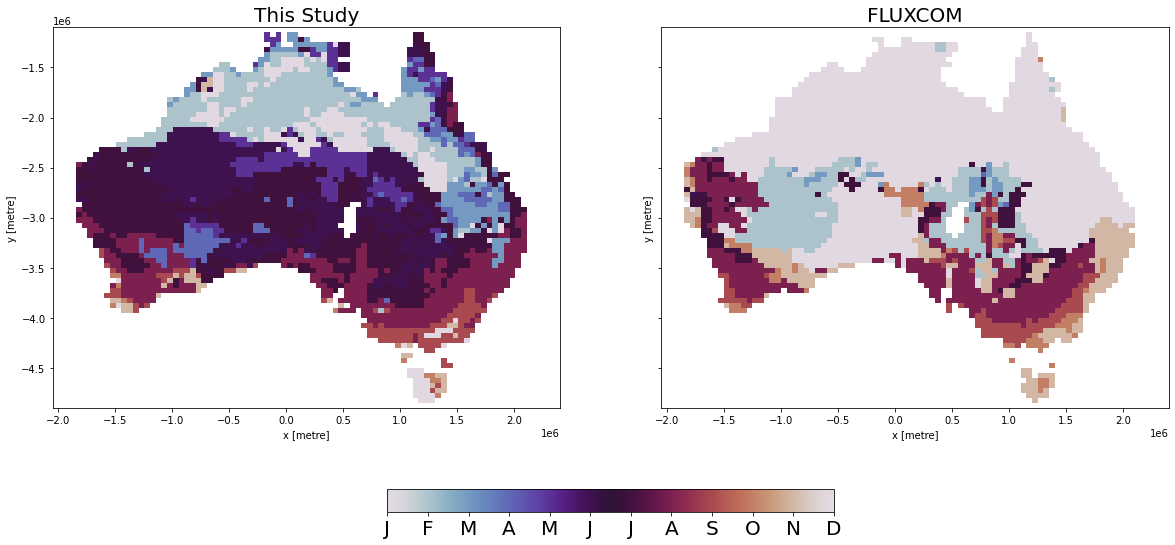

In [37]:
fig,ax = plt.subplots(1,2, figsize=(20,10), sharey=True)

im = max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[0], cmap='twilight', add_colorbar=False)
ax[0].set_title('This Study', fontsize=20);

im = max_mean_month_fc.plot.imshow(vmin=1, vmax=12, ax=ax[1], cmap='twilight', add_colorbar=False)

cbar = fig.colorbar(im, spacing='uniform', ax=ax.ravel().tolist(), orientation='horizontal', shrink=0.4)
cbar.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12])
cbar.set_ticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=20)
ax[1].set_title('FLUXCOM', fontsize=20);

# cmap = ListedColormap(['lightsteelblue', 'cornflowerblue', 'royalblue', 'darkblue'])
# im1 = max_mean_season.plot.imshow(vmin=1, vmax=4, cmap=cmap, add_colorbar=False, ax=ax[1])
# cbar1 = plt.colorbar(im1, spacing='uniform', ax=ax[1])
# cbar1.set_ticks([1, 2, 3, 4])
# cbar1.set_ticklabels(["DJF", "MAM", "JJA", "SON"])
# ax[1].set_title('Season of maximum '+var)
# plt.tight_layout();